# Stock Prediction with Transformers

In this notebook, stock prediction is performed using data extracted from Yahoo Finance, different features used in finance are created, and a Transformer-based network is trained and tested.

In [1]:
#We import necessary libraries
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torchmetrics
from torch.utils.data import DataLoader, TensorDataset

import math
from utils.functions import *

We imported the data from yahoo finance

In [2]:
#We downloaded the data using yahoo finance
start_date = dt.datetime(2022, 1, 1)
end_date = dt.datetime(2024, 1, 1)# dt.datetime.now()


# Energy Stocks
energy_stocks = ['ENPH', 'FSLR', 'SHEL','XOM', 'CVX','BP', 'TTE', 'NEE', 'DUK', ] #
stock_data = {stock: get_data(stock, start_date, end_date) for stock in energy_stocks}

# Energy Indices
energy_indices = ['^GSPE', 'ICLN']
index_data = {index: get_data(index, start_date, end_date) for index in energy_indices}


index_data = pd.DataFrame.from_dict(index_data)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


We define the function with which the transformer is trained, note that we already defined the transformer in the functions.py file

In [3]:
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001):

    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    mape_metric = torchmetrics.MeanAbsolutePercentageError()
    rmse_metric = torchmetrics.MeanSquaredError(squared=False)  
    
    losses = {'train':[], 'val':[]}
    metrics = {'mape_train':[], 'mape_val':[],
               'rmse_train':[], 'rmse_val':[]}
    
    for epoch in range(epochs):
       
        mape_metric.reset()
        rmse_metric.reset()

        model.train()
        train_loss, train_mape, train_rmse = 0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)  
            loss = loss_function(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_mape += mape_metric(y_pred, y_batch).item() 
            train_rmse += rmse_metric(y_pred, y_batch).item() 

        train_loss /= len(train_loader)
        train_mape /= len(train_loader)
        train_rmse /= len(train_loader)

        model.eval()
        val_loss, val_mape, val_rmse = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)  # Permute for transformer input (seq_len, batch, features)

                loss = loss_function(y_pred, y_batch)
                val_loss += loss.item()

                val_mape += mape_metric(y_pred, y_batch).item() 
                val_rmse += rmse_metric(y_pred, y_batch).item() 


        val_loss /= len(val_loader)
        val_mape /= len(val_loader)
        val_rmse /= len(val_loader)


        losses['train'].append(train_loss)
        losses['val'].append(val_loss)
        metrics['mape_train'].append(train_mape)
        metrics['mape_val'].append(val_mape)
        metrics['rmse_train'].append(train_rmse)
        metrics['rmse_val'].append(val_rmse)


        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'  Train MAPE: {train_mape:.2f}%, Validation MAPE: {val_mape:.2f}%')
            print(f'  Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}')


    return losses, metrics


def make_predictions(model, X):
    model.eval()
    with torch.no_grad():
        predictions = model(X)
    return predictions.detach().numpy()

In addition to the stock, we include variables typically used in finance.

Note that these new features have been obtained causally, so there is no data leakage.

In [4]:
df_stock_data = pd.DataFrame.from_dict(stock_data)

#Simple Moving Average 
df_sma_5 = compute_sma(df_stock_data, 5)
df_sma_20 = compute_sma(df_stock_data, 20)
# Exponential Moving Average
df_ema_5 = compute_ema(df_stock_data, 5)
 #Relative Strength Index 
df_rsi_14 = compute_rsi(df_stock_data, 14)
#Moving Average Convergence Divergence 
df_macd, df_macd_signal = compute_macd(df_stock_data)
#Volatility (Standard Deviation or Bollinger Bands)
df_bb_upper, df_bb_lower = compute_bollinger_bands(df_stock_data, 20)

df_stock_data[df_sma_5.columns] = df_sma_5
df_stock_data[df_sma_20.columns] = df_sma_20
df_stock_data[df_ema_5.columns] = df_ema_5
df_stock_data[df_rsi_14.columns] = df_rsi_14
df_stock_data[df_macd.columns] = df_macd
df_stock_data[df_macd_signal.columns] = df_macd_signal
df_stock_data[df_bb_upper.columns] = df_bb_upper
df_stock_data[df_bb_lower.columns] = df_bb_lower


df_dates = add_date_features(df_stock_data) 

df_stock_data[df_dates.columns] = df_dates

df_stock_data.dropna(axis=0, inplace=True)


Below we visualize these new features, in particular the new features for the 'TTE' target are graphed. Note that the graphs are for the same stock, but due to the scale of the different features, a subplot has been made.

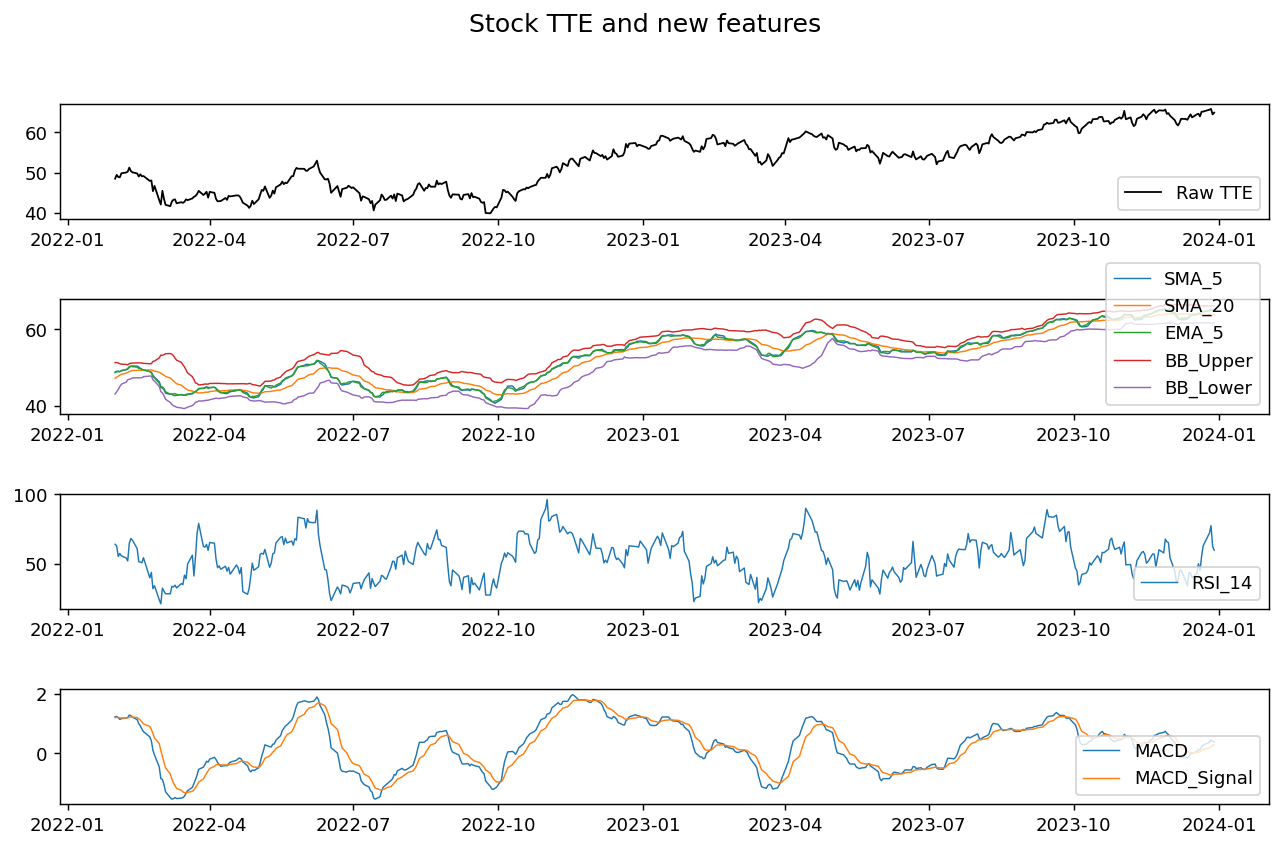

In [5]:
name_target ='TTE'

fig, ax = plt.subplots(nrows=4,figsize=(12, 7), dpi=130)
plt.suptitle('Stock '+name_target+' and new features', size=14)
ax[0].plot(df_stock_data[name_target], label ='Raw '+name_target, color= 'k',linewidth=1)
ax[1].plot(df_stock_data[name_target+'_SMA_5'], label ='SMA_5', linewidth=0.8)
ax[1].plot(df_stock_data[name_target+'_SMA_20'], label ='SMA_20', linewidth=0.8)
ax[1].plot(df_stock_data[name_target+'_EMA_5'], label ='EMA_5', linewidth=0.8)
ax[1].plot(df_stock_data[name_target+'_BB_Upper'], label ='BB_Upper', linewidth=0.8)
ax[1].plot(df_stock_data[name_target+'_BB_Lower'], label ='BB_Lower', linewidth=0.8)


ax[2].plot(df_stock_data[name_target+'_RSI_14'], label ='RSI_14', linewidth=0.8)
ax[3].plot(df_stock_data[name_target+'_MACD'], label ='MACD', linewidth=0.8)
ax[3].plot(df_stock_data[name_target+'_MACD_Signal'], label ='MACD_Signal', linewidth=0.8)


ax[0].legend(loc=4)
ax[1].legend(loc=4)
ax[2].legend(loc=4)
ax[3].legend(loc=4)
plt.subplots_adjust(hspace=0.7,)

plt.show()

We divide the database into train, validation and test

In [6]:
split_idx_train = int(len(df_stock_data) * 0.6)
split_idx_val = int(len(df_stock_data) * 0.2)


train_df = df_stock_data[:split_idx_train]
val_df = df_stock_data[split_idx_train:split_idx_train + split_idx_val]
test_df = df_stock_data[split_idx_train + split_idx_val:]


print('date range train: {} - {} '.format(train_df.index[0],train_df.index[-1]))
print('date range val: {} - {} '.format(val_df.index[0],val_df.index[-1]))
print('date range test: {} - {} '.format(test_df.index[0],test_df.index[-1]))



date range train: 2022-01-31 00:00:00 - 2023-03-24 00:00:00 
date range val: 2023-03-27 00:00:00 - 2023-08-11 00:00:00 
date range test: 2023-08-14 00:00:00 - 2023-12-29 00:00:00 


We decide which features and target we want to use in the model, also we do the preprocessing, so we set the window size and the type of scale to use

In [7]:
#Define the target and features to use
name_target ='TTE' #
name_features = train_df.columns.to_list() # [ 'TTE ,'ENPH', 'FSLR', 'SHEL' ]#
window_size = 10

name_scale = 'MinMax'  # 'MinMax', 'StandardScaler'

In [8]:
#Preprocessing
train_X, train_y, info_dates_train, scaler, idx_target = preprocess_data(train_df, name_target, name_features, window_size, scaler=name_scale)
val_X, val_y, info_dates_val, _, _ = preprocess_data(val_df, name_target, name_features, window_size, scaler)
test_X, test_y, info_dates_test, _, _ = preprocess_data(test_df, name_target, name_features, window_size, scaler)

#Dataloader
train_X_tensor, train_y_tensor = torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32)
val_X_tensor, val_y_tensor = torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_y, dtype=torch.float32)
test_X_tensor, test_y_tensor = torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(train_X_tensor, train_y_tensor), batch_size=10, shuffle=True)
val_loader = DataLoader(TensorDataset(val_X_tensor, val_y_tensor), batch_size=10)
test_loader = DataLoader(TensorDataset(test_X_tensor, test_y_tensor))



The hyperparameters with which the model will be trained are established

In [9]:
#Parameters
input_size = train_X.shape[-1]
d_model = 32
nhead = 4
num_layers =1
max_len = 60

model = modelTransformer(num_layers=num_layers, d_model=d_model, nhead=nhead, input_size=input_size, max_len=max_len)

losses, metrics = train_model(model, train_loader, val_loader, epochs=100, lr=0.001)

/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100:
  Train Loss: 0.0858, Validation Loss: 0.0221
  Train MAPE: 1262.87%, Validation MAPE: 0.15%
  Train RMSE: 0.2647, Validation RMSE: 0.1354
Epoch 11/100:
  Train Loss: 0.0070, Validation Loss: 0.0062
  Train MAPE: 245.66%, Validation MAPE: 0.08%
  Train RMSE: 0.0805, Validation RMSE: 0.0747
Epoch 21/100:
  Train Loss: 0.0042, Validation Loss: 0.0070
  Train MAPE: 317.94%, Validation MAPE: 0.09%
  Train RMSE: 0.0633, Validation RMSE: 0.0786
Epoch 31/100:
  Train Loss: 0.0045, Validation Loss: 0.0081
  Train MAPE: 9.18%, Validation MAPE: 0.10%
  Train RMSE: 0.0662, Validation RMSE: 0.0851
Epoch 41/100:
  Train Loss: 0.0033, Validation Loss: 0.0076
  Train MAPE: 349.14%, Validation MAPE: 0.09%
  Train RMSE: 0.0557, Validation RMSE: 0.0803
Epoch 51/100:
  Train Loss: 0.0033, Validation Loss: 0.0054
  Train MAPE: 187.12%, Validation MAPE: 0.07%
  Train RMSE: 0.0562, Validation RMSE: 0.0695
Epoch 61/100:
  Train Loss: 0.0032, Validation Loss: 0.0055
  Train MAPE: 58.31%, Validati

Once the model is trained, final predictions can be made

In [10]:
#Predictions
train_pred_scaled = make_predictions(model, train_X_tensor)
val_pred_scaled = make_predictions(model, val_X_tensor)
test_pred_scaled = make_predictions(model, test_X_tensor)


#Real Data
train_real = train_df[name_target][window_size:]
val_real = val_df[name_target][window_size:]
test_real = test_df[name_target][window_size:]

real_combined = pd.concat((train_real, val_real, test_real))


If we scale the data, we have to descale the prediction to have the results on the same scale.

In [11]:
#Unscale the predictions

if name_scale == 'Without':

    train_pred_unscaled = train_pred_scaled
    val_pred_unscaled = val_pred_scaled
    test_pred_unscaled = test_pred_scaled

else:
    zeros_shape_scaler = np.zeros((len(train_pred_scaled), len(name_features)))
    zeros_shape_scaler[:,idx_target] = train_pred_scaled
    train_pred_unscaled = scaler.inverse_transform(zeros_shape_scaler)[:,idx_target]

    zeros_shape_scaler = np.zeros((len(val_pred_scaled), len(name_features)))
    zeros_shape_scaler[:,idx_target] = val_pred_scaled
    val_pred_unscaled = scaler.inverse_transform(zeros_shape_scaler)[:,idx_target]


    zeros_shape_scaler = np.zeros((len(test_pred_scaled), len(name_features)))
    zeros_shape_scaler[:,idx_target] = test_pred_scaled
    test_pred_unscaled = scaler.inverse_transform(zeros_shape_scaler)[:,idx_target]

#final metrics:


mape_metric = torchmetrics.MeanAbsolutePercentageError()
rmse_metric = torchmetrics.MeanSquaredError(squared=False)  

metrics_final = {
            'rmse_train': rmse_metric(torch.tensor(train_pred_unscaled), torch.tensor(train_real.values)).item(),
            'mape_train': mape_metric(torch.tensor(train_pred_unscaled), torch.tensor(train_real.values)).item(),
            'rmse_val': rmse_metric(torch.tensor(val_pred_unscaled), torch.tensor(val_real.values)).item(),
            'mape_val': mape_metric(torch.tensor(val_pred_unscaled), torch.tensor(val_real.values)).item(),
            'rmse_test': rmse_metric(torch.tensor(test_pred_unscaled), torch.tensor(test_real.values)).item(),
            'mape_test': mape_metric(torch.tensor(test_pred_unscaled), torch.tensor(test_real.values)).item(),
            
            
            }
ds = pd.Series(metrics_final)
ds.round(3)

rmse_train    1.027
mape_train    0.017
rmse_val      1.694
mape_val      0.025
rmse_test     6.450
mape_test     0.096
dtype: float64

Finally we graph the results, metrics and losses

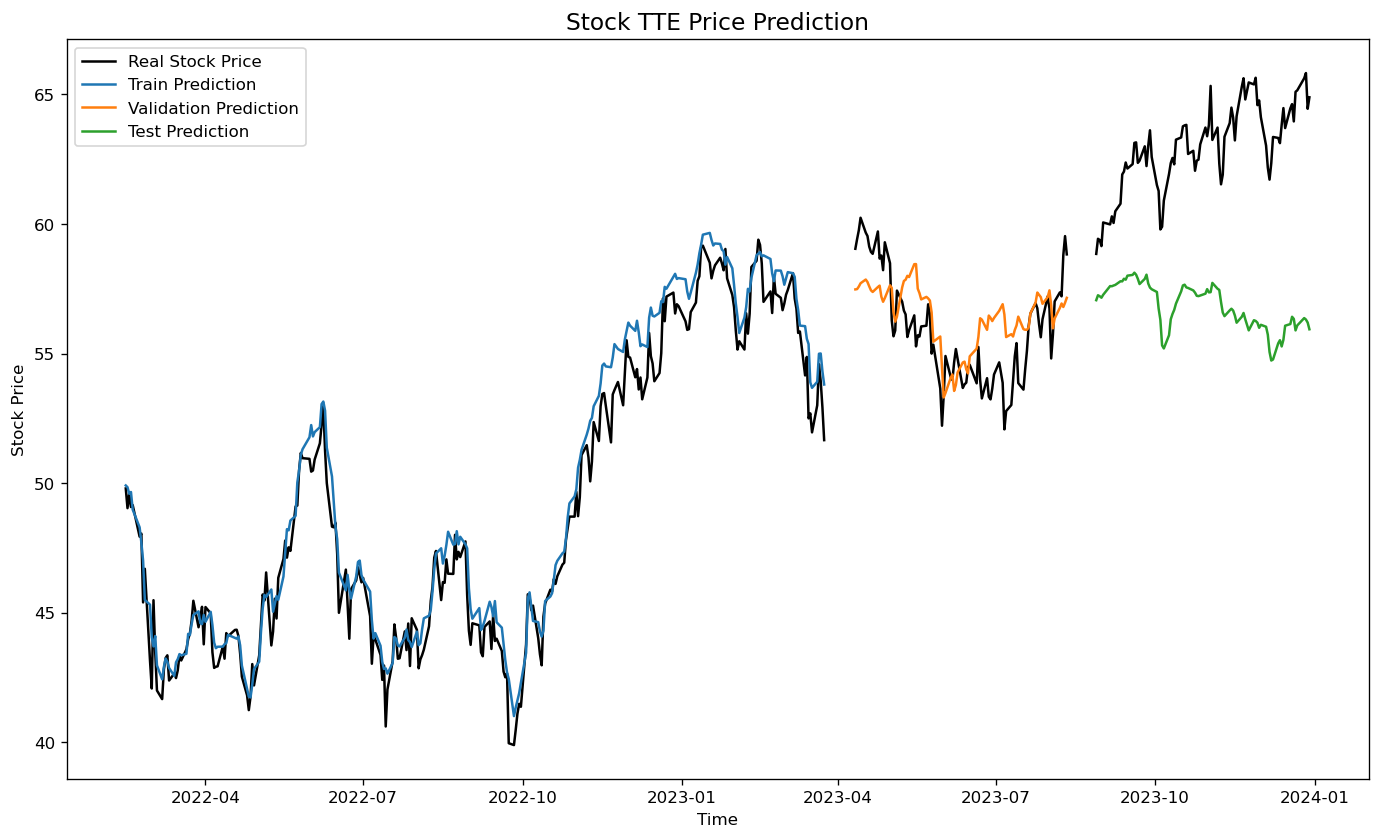

In [12]:
plot_results(real_combined, train_real, val_real, test_real, 
                train_pred_unscaled, val_pred_unscaled, test_pred_unscaled)

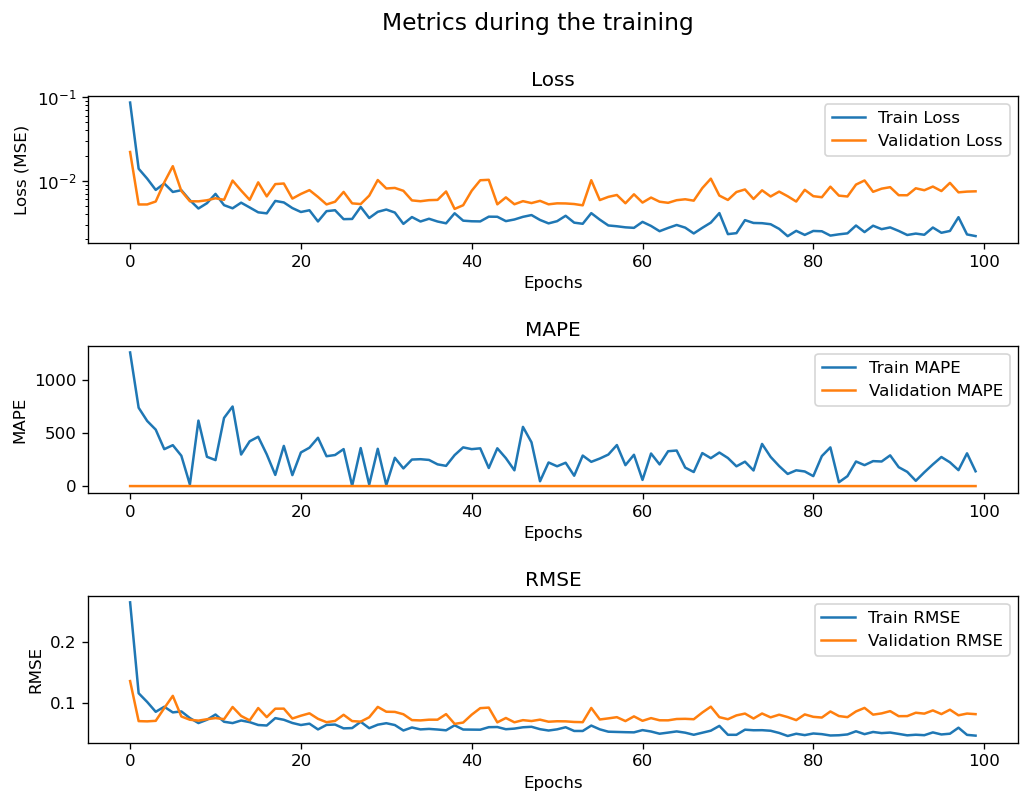

In [13]:
plot_metrics(losses, metrics)
